In [18]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [19]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [20]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


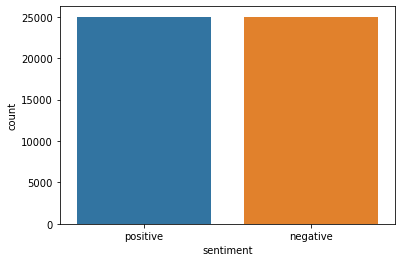

In [12]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [22]:
movie_reviews["review"][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [14]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [15]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [16]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [23]:
X[1]

'A wonderful little production The filming technique is very unassuming very old time BBC fashion and gives comforting and sometimes discomforting sense of realism to the entire piece The actors are extremely well chosen Michael Sheen not only has got all the polari but he has all the voices down pat too You can truly see the seamless editing guided by the references to Williams diary entries not only is it well worth the watching but it is terrificly written and performed piece masterful production about one of the great master of comedy and his life The realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears It plays on our knowledge and our senses particularly with the scenes concerning Orton and Halliwell and the sets particularly of their flat with Halliwell murals decorating every surface are terribly well done '

In [24]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=47)

In [48]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [49]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [51]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [52]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [53]:
from tensorflow.keras.layers import Conv1D
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [54]:
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          9021700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,085,957
Trainable params: 64,257
Non-trainable params: 9,021,700
_________________________________________________________________
None


In [55]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
235/235 [==============================] - 8s 33ms/step - loss: 0.4999 - acc: 0.7527 - val_loss: 0.3959 - val_acc: 0.8245
Epoch 2/6
235/235 [==============================] - 7s 32ms/step - loss: 0.3659 - acc: 0.8376 - val_loss: 0.3798 - val_acc: 0.8268
Epoch 3/6
235/235 [==============================] - 7s 31ms/step - loss: 0.3169 - acc: 0.8660 - val_loss: 0.3670 - val_acc: 0.8343
Epoch 4/6
235/235 [==============================] - 8s 33ms/step - loss: 0.2805 - acc: 0.8858 - val_loss: 0.3498 - val_acc: 0.8405
Epoch 5/6
235/235 [==============================] - 8s 34ms/step - loss: 0.2433 - acc: 0.9056 - val_loss: 0.3895 - val_acc: 0.8248
Epoch 6/6
391/391 [==============================] - 1s 4ms/step - loss: 0.3538 - acc: 0.8434


In [56]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3538230359554291
Test Accuracy: 0.8433600068092346


In [57]:
from tensorflow.keras.layers import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [58]:
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          9021700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,139,077
Trainable params: 117,377
Non-trainable params: 9,021,700
_________________________________________________________________
None


In [60]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
235/235 [==============================] - 41s 176ms/step - loss: 0.3088 - acc: 0.8674 - val_loss: 0.3326 - val_acc: 0.8508
Epoch 2/6
235/235 [==============================] - 43s 182ms/step - loss: 0.2941 - acc: 0.8769 - val_loss: 0.3346 - val_acc: 0.8515
Epoch 3/6
235/235 [==============================] - 43s 181ms/step - loss: 0.2742 - acc: 0.8834 - val_loss: 0.3334 - val_acc: 0.8628
Epoch 4/6
235/235 [==============================] - 45s 191ms/step - loss: 0.2570 - acc: 0.8927 - val_loss: 0.3285 - val_acc: 0.8584
Epoch 5/6
235/235 [==============================] - 42s 179ms/step - loss: 0.2415 - acc: 0.8994 - val_loss: 0.3421 - val_acc: 0.8581
Epoch 6/6
391/391 [==============================] - 11s 28ms/step - loss: 0.3489 - acc: 0.8566


In [61]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.34890174865722656
Test Accuracy: 0.8566399812698364
